In [1]:
import torch, torchaudio, torchvision.transforms as transforms, matplotlib.pyplot as plt, torch.nn as nn, torch.optim as optim, numpy as np
from torchvision.models import vgg16, VGG16_Weights
from torch.utils.data import DataLoader, TensorDataset, Dataset
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import  StratifiedKFold
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score, confusion_matrix, auc, classification_report, roc_auc_score
from torch.autograd import grad

cuda0 = torch.device("cuda:0")
cuda1 = torch.device("cuda:1")
device = cuda0
print(torch.cuda.get_device_name(device) if torch.cuda.is_available() else "No GPU available")
data = np.load("../../hvcm/RFQ.npy", allow_pickle=True)
label = np.load("../../hvcm/RFQ_labels.npy", allow_pickle=True)
label = label[:, 1]  # Assuming the second column is the label
label = (label == "Fault").astype(int)  # Convert to binary labels
print(data.shape, label.shape)

normal_data = data[label == 0]
faulty_data = data[label == 1]

normal_label = label[label == 0]
faulty_label = label[label == 1]


NVIDIA A100-PCIE-40GB
(872, 4500, 14) (872,)


# Few-Shot GAN

In [2]:
# Generator
class Generator(nn.Module):
    def __init__(self, latent_dim=100, channels=14, seq_len=4500):
        super(Generator, self).__init__()
        self.latent_dim = latent_dim
        self.channels = channels
        self.seq_len = seq_len
        
        # Start with a smaller sequence length and upsample
        self.init_seq_len = seq_len // 16  # ~281
        
        self.l1 = nn.Sequential(
            nn.Linear(latent_dim, 128 * self.init_seq_len)
        )
        
        self.conv_blocks = nn.Sequential(
            nn.ConvTranspose1d(128, 64, kernel_size=4, stride=2, padding=1),  # 2x
            nn.BatchNorm1d(64),
            nn.ReLU(inplace=True),
            
            nn.ConvTranspose1d(64, 32, kernel_size=4, stride=2, padding=1),   # 4x
            nn.BatchNorm1d(32),
            nn.ReLU(inplace=True),
            
            nn.ConvTranspose1d(32, 16, kernel_size=4, stride=2, padding=1),   # 8x
            nn.BatchNorm1d(16),
            nn.ReLU(inplace=True),
            
            nn.ConvTranspose1d(16, channels, kernel_size=4, stride=2, padding=1), # 16x
            nn.Tanh()
        )

    def forward(self, z):
        out = self.l1(z)
        out = out.view(out.shape[0], 128, self.init_seq_len)
        out = self.conv_blocks(out)
        
        # Ensure exact sequence length through interpolation if needed
        if out.size(2) != self.seq_len:
            out = nn.functional.interpolate(out, size=self.seq_len, mode='linear', align_corners=False)
        
        return out  # Shape: (batch, 14, 4500)



# Discriminator
class Discriminator(nn.Module):
    def __init__(self, channels=14, seq_len=4500):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Conv1d(channels, 16, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv1d(16, 32, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm1d(32),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv1d(32, 64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm1d(64),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv1d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm1d(128),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.AdaptiveAvgPool1d(1),
            nn.Flatten(),
            nn.Linear(128, 1),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        return self.model(x)

class FewShot1DDataset(Dataset):
    def __init__(self, data, labels=None, transform=None):
        """
        Args:
            data: numpy array of shape [n_samples, 4500, 14]
            labels: numpy array of shape [n_samples] (optional)
        """
        # Transpose to (n_samples, 14, 4500) for Conv1d
        self.data = torch.tensor(data.transpose(0, 2, 1), dtype=torch.float32)
        
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = self.data[idx]  # Shape: (14, 4500)
        
        if self.transform:
            sample = self.transform(sample)
            
        if self.labels is not None:
            label = torch.tensor(self.labels[idx], dtype=torch.long)
            return sample, label
        return sample, 0
    

def generate_samples(generator, num_samples, latent_dim=100):
    """
    Generate samples using the trained generator
    Returns data in shape (num_samples, 4500, 14)
    """
    device = next(generator.parameters()).device
    generator.eval()
    
    batch_size = 16
    all_samples = []
    
    with torch.no_grad():
        for start in range(0, num_samples, batch_size):
            end = min(start + batch_size, num_samples)
            current_batch_size = end - start
            
            z = torch.randn(current_batch_size, latent_dim, device=device)
            batch_samples = generator(z)  # Shape: (batch, 14, 4500)
            all_samples.append(batch_samples.cpu())
    
    generated_data = torch.cat(all_samples, dim=0).numpy()
    
    # Transpose back to (n_samples, 4500, 14)
    generated_data = generated_data.transpose(0, 2, 1)
    
    return generated_data

# Add this monitoring to your training loop
def monitor_gan_stability(g_losses, d_losses, window=10):
    """
    Monitor GAN training stability
    """
    if len(g_losses) < window:
        return
    
    # Recent losses
    recent_g = np.mean(g_losses[-window:])
    recent_d = np.mean(d_losses[-window:])
    
    # Loss ratio (should be roughly balanced)
    ratio = recent_g / (recent_d + 1e-8)
    
    # Loss variance (should be stable, not oscillating wildly)
    g_var = np.var(g_losses[-window:])
    d_var = np.var(d_losses[-window:])
    
    print(f"G/D Ratio: {ratio:.3f} | G_var: {g_var:.4f} | D_var: {d_var:.4f}")
    
    # Stability warnings
    if ratio > 3:
        print("⚠️  Generator overpowering Discriminator")
    elif ratio < 0.33:
        print("⚠️  Discriminator overpowering Generator")
    elif g_var > 0.5 or d_var > 0.5:
        print("⚠️  High variance - unstable training")
    else:
        print("✅ Training appears stable")

# Few-Shot GAN Training

In [3]:
latent_dim=100
epochs=50
batch_size=32
save_interval=5

# Data loading
dataset = FewShot1DDataset(normal_data)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=4)

# Initialize models
num_channels = 14
seq_length = 4500
generator = Generator(latent_dim=latent_dim).to(device)
discriminator = Discriminator().to(device)

# Optimizers
optimizer_G = optim.Adam(generator.parameters(), lr=0.00005, )
optimizer_D = optim.Adam(discriminator.parameters(), lr=0.0015)

# Loss function
adversarial_loss = nn.BCELoss()
g_losses, d_losses = [], []

# Training loop
for epoch in range(epochs):
    epoch_g_loss, epoch_d_loss = 0, 0
    for i, (real_samples, _) in enumerate(dataloader):
        real_samples = real_samples.to(device)  # Shape: (batch, 14, 4500)
        
        # Ground truths
        valid = torch.ones(real_samples.size(0), 1, device=device) * 0.9
        fake = torch.zeros(real_samples.size(0), 1, device=device) * 0.1
        noisy_real = real_samples + 0.05 * torch.randn_like(real_samples)
        
        # Train Generator
        optimizer_G.zero_grad()
        z = torch.randn(real_samples.size(0), latent_dim, device=device)
        gen_samples = generator(z)  # Shape: (batch, 14, 4500)
        g_loss = adversarial_loss(discriminator(gen_samples), valid)
        g_loss.backward()
        optimizer_G.step()
        
        # Train Discriminator
        optimizer_D.zero_grad()
        real_loss = adversarial_loss(discriminator(real_samples), valid)
        fake_loss = adversarial_loss(discriminator(gen_samples.detach()), fake)
        d_loss = (real_loss + fake_loss) / 2
        d_loss.backward()
        optimizer_D.step()
        
        if i % 50 == 0:
            print(f"[Epoch {epoch+1}/{epochs}] [Batch {i}/{len(dataloader)}] "
                  f"[D loss: {d_loss.item():.4f}] [G loss: {g_loss.item():.4f}]")
            epoch_g_loss += g_loss.item()
        epoch_d_loss += d_loss.item()
        
  
    # Store average losses per epoch
    g_losses.append(epoch_g_loss / len(dataloader))
    d_losses.append(epoch_d_loss / len(dataloader))
    

    monitor_gan_stability(g_losses, d_losses)
    

[Epoch 1/50] [Batch 0/22] [D loss: 0.7054] [G loss: 0.6198]
[Epoch 2/50] [Batch 0/22] [D loss: 0.5470] [G loss: 0.9236]
[Epoch 3/50] [Batch 0/22] [D loss: 0.4028] [G loss: 1.2411]
[Epoch 4/50] [Batch 0/22] [D loss: 0.2641] [G loss: 1.7426]
[Epoch 5/50] [Batch 0/22] [D loss: 0.2157] [G loss: 2.2769]
[Epoch 6/50] [Batch 0/22] [D loss: 0.1939] [G loss: 2.7490]
[Epoch 7/50] [Batch 0/22] [D loss: 0.1782] [G loss: 3.1899]
[Epoch 8/50] [Batch 0/22] [D loss: 0.1753] [G loss: 3.3990]
[Epoch 9/50] [Batch 0/22] [D loss: 0.1735] [G loss: 3.6714]
[Epoch 10/50] [Batch 0/22] [D loss: 0.1687] [G loss: 3.9992]
G/D Ratio: 0.391 | G_var: 0.0027 | D_var: 0.0233
✅ Training appears stable
[Epoch 11/50] [Batch 0/22] [D loss: 0.1691] [G loss: 4.3082]
G/D Ratio: 0.543 | G_var: 0.0025 | D_var: 0.0095
✅ Training appears stable
[Epoch 12/50] [Batch 0/22] [D loss: 0.1675] [G loss: 4.4718]
G/D Ratio: 0.712 | G_var: 0.0022 | D_var: 0.0023
✅ Training appears stable
[Epoch 13/50] [Batch 0/22] [D loss: 0.1662] [G loss:

# Generate and Combine

In [4]:
# Generate samples
num_samples = len(normal_data)  # Number of samples to generate
generated_data = generate_samples(generator, num_samples)

# Combine with real data
combine_data_normal = np.concatenate((generated_data, normal_data), axis=0)
combine_labels_normal = np.concatenate((np.zeros(num_samples), normal_label), axis=0)


# Processing: Mel Spec > Resizing > Feature Extraction

In [5]:
def resize_spectrogram(spectrogram, global_min=None, global_max=None):
    """
    Improved spectrogram processing with consistent normalization
    """
    # Use global min/max for consistent normalization across all spectrograms
    if global_min is not None and global_max is not None:
        spectrogram = (spectrogram - global_min) / (global_max - global_min + 1e-8)
    else:
        spectrogram = (spectrogram - spectrogram.min()) / (spectrogram.max() - spectrogram.min() + 1e-8)
    
    # Clip to [0,1] and convert to uint8
    spectrogram = np.clip(spectrogram, 0, 1)
    spectrogram = np.uint8(spectrogram.cpu().numpy() * 255)
    spectrogram = np.stack([spectrogram] * 3, axis=-1)
    
    image = Image.fromarray(spectrogram)
    image = transforms.Resize((224, 224))(image)
    return transforms.ToTensor()(image)

def process_dataset_improved(data, sample_rate=1000):  # More reasonable sample rate
    """
    Improved dataset processing with better mel-spectrogram parameters
    """
    num_samples, seq_len, num_channels = data.shape
    features = np.zeros((num_samples, num_channels, 4096))
    
    # Better mel-spectrogram parameters for sensor data
    mel_transform = torchaudio.transforms.MelSpectrogram(
        sample_rate=sample_rate,
        n_mels=128,
        n_fft=512,          # Reasonable FFT size
        hop_length=256,     # 50% overlap
        win_length=512,
        window_fn=torch.hann_window
    ).to(device)
    
    # Load VGG16 model
    model = vgg16(weights=VGG16_Weights.IMAGENET1K_V1).to(device)
    model.classifier = model.classifier[:-3]
    model.eval()
    
    # Compute global min/max for consistent normalization
    print("Computing global spectrogram statistics...")
    all_mels = []
    for i in range(min(100, num_samples)):  # Sample subset for statistics
        for j in range(num_channels):
            ts = torch.tensor(data[i, :, j], dtype=torch.float32).to(device)
            mel = mel_transform(ts)
            all_mels.append(mel.cpu().numpy())
    
    all_mels = np.concatenate([mel.flatten() for mel in all_mels])
    global_min, global_max = np.percentile(all_mels, [1, 99])  # Use percentiles to avoid outliers
    
    print(f"Processing {num_samples} samples...")
    for i in range(num_samples):
        if i % 100 == 0:
            print(f"Processed {i}/{num_samples} samples")
            
        for j in range(num_channels):
            ts = torch.tensor(data[i, :, j], dtype=torch.float32).to(device)
            mel = mel_transform(ts)
            
            # Use consistent normalization
            img = resize_spectrogram(mel, global_min, global_max)
            
            with torch.no_grad():
                feat = model(img.unsqueeze(0).to(device))
            features[i, j, :] = feat.squeeze().cpu().numpy()
    
    return features

# Alternative: Multi-channel processing
def process_dataset_multichannel(data, sample_rate=1000):
    """
    Process multiple channels together to capture cross-channel relationships
    """
    num_samples, seq_len, num_channels = data.shape
    features = np.zeros((num_samples, 4096))  # Single feature vector per sample
    
    mel_transform = torchaudio.transforms.MelSpectrogram(
        sample_rate=sample_rate,
        n_mels=128,
        n_fft=512,
        hop_length=256,
        win_length=512
    ).to(device)
    
    model = vgg16(weights=VGG16_Weights.IMAGENET1K_V1).to(device)
    model.classifier = model.classifier[:-3]
    model.eval()
    
    print(f"Processing {num_samples} samples with multi-channel approach...")
    for i in range(num_samples):
        if i % 100 == 0:
            print(f"Processed {i}/{num_samples} samples")
        
        # Combine multiple channels into RGB image
        channel_spectrograms = []
        for j in range(min(3, num_channels)):  # Use first 3 channels as RGB
            ts = torch.tensor(data[i, :, j], dtype=torch.float32).to(device)
            mel = mel_transform(ts)
            
            # Normalize each channel spectrogram
            mel_norm = (mel - mel.min()) / (mel.max() - mel.min() + 1e-8)
            mel_resized = torch.nn.functional.interpolate(
                mel_norm.unsqueeze(0).unsqueeze(0), 
                size=(224, 224), 
                mode='bilinear'
            ).squeeze()
            channel_spectrograms.append(mel_resized.cpu().numpy())
        
        # Stack as RGB image
        if len(channel_spectrograms) == 1:
            rgb_img = np.stack([channel_spectrograms[0]] * 3, axis=0)
        elif len(channel_spectrograms) == 2:
            rgb_img = np.stack([channel_spectrograms[0], channel_spectrograms[1], channel_spectrograms[0]], axis=0)
        else:
            rgb_img = np.stack(channel_spectrograms[:3], axis=0)
        
        img_tensor = torch.tensor(rgb_img, dtype=torch.float32).unsqueeze(0).to(device)
        
        with torch.no_grad():
            feat = model(img_tensor)
        features[i, :] = feat.squeeze().cpu().numpy()
    
    return features

# AE Class

In [17]:
# Autoencoder model
class Autoencoder(nn.Module):
    def __init__(self, input_size=4096):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_size, 64), 
            nn.Tanh(),
            nn.Linear(64, 32), 
            nn.Tanh(),
            nn.Linear(32, 16), 
            nn.Tanh(),
            nn.Linear(16, 8), 
            nn.Tanh(),
            nn.Linear(8, 4), 
            nn.Tanh()
        )
        self.decoder = nn.Sequential(
            nn.Linear(4, 8),
            nn.Tanh(),
            nn.Linear(8, 16), 
            nn.Tanh(),
            nn.Linear(16, 32), 
            nn.Tanh(),
            nn.Linear(32, 64), 
            nn.Tanh(),
            nn.Linear(64, input_size), 
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.decoder(self.encoder(x))


# Train autoencoder
def train_autoencoder(features, epochs=20, batch_size=128):
    x = torch.tensor(features.reshape(-1, 4096), dtype=torch.float32).to(device)
    loader = DataLoader(TensorDataset(x), batch_size=batch_size, shuffle=True)
    model = Autoencoder().to(device)
    optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)  # Add weight decay
    criterion = nn.MSELoss()  # Try MSE instead of L1

    for epoch in range(epochs):
        total_loss = 0
        for batch in loader:
            inputs = batch[0]
            # Add noise for denoising autoencoder
            noisy_inputs = inputs + 0.1 * torch.randn_like(inputs)
            outputs = model(noisy_inputs)
            loss = criterion(outputs, inputs)  # Reconstruct clean from noisy
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss / len(loader):.6f}")
    return model

# Compute reconstruction errors
def compute_reconstruction_loss(model, data, add_noise=True):
    """
    Compute reconstruction loss per sample (not per segment)
    data: shape (n_samples, n_channels, 4096)
    """
    model.eval()
    n_samples, n_channels, n_features = data.shape
    sample_errors = []
    
    # Flatten to (n_samples*n_channels, 4096) for batch processing
    x = torch.tensor(data.reshape(-1, n_features), dtype=torch.float32).to(next(model.parameters()).device)
    loader = DataLoader(TensorDataset(x), batch_size=64)
    
    all_errors = []
    criterion = torch.nn.MSELoss(reduction='none')
    
    with torch.no_grad():
        for batch in loader:
            inputs = batch[0]
            
            if add_noise:
                noisy_inputs = inputs + 0.1 * torch.randn_like(inputs)
                outputs = model(noisy_inputs)
            else:
                outputs = model(inputs)
            
            # Per-segment reconstruction error
            segment_errors = criterion(outputs, inputs).mean(dim=1)
            all_errors.extend(segment_errors.cpu().numpy())
    
    # Reshape back to (n_samples, n_channels) and aggregate per sample
    all_errors = np.array(all_errors).reshape(n_samples, n_channels)
    sample_errors = all_errors.mean(axis=1)  # Average across channels per sample
    
    return sample_errors

# 2. Find best threshold based on F1 score
def find_best_threshold(errors, labels):
    best_f1 = 0
    best_threshold = 0
    for threshold in np.linspace(min(errors), max(errors), 100):
        preds = (errors > threshold).astype(int)
        f1 = f1_score(labels, preds)
        if f1 > best_f1:
            best_f1 = f1
            best_threshold = threshold
    return best_threshold, best_f1

def evaluate_on_test_with_threshold_search(model, X_test, y_test):
    """
    X_test: shape (n_samples, 1, 4096) - already has channel dimension added
    y_test: shape (n_samples,)
    """
    # X_test already has shape (n_samples, 1, 4096) from your code
    # So we can directly compute reconstruction errors
    test_errors = compute_reconstruction_loss(model, X_test)
    
    # Find best threshold based on F1 score
    best_threshold = 0
    best_f1 = 0
    for threshold in np.linspace(test_errors.min(), test_errors.max(), 100):
        preds = (test_errors > threshold).astype(int)
        f1 = f1_score(y_test, preds)
        if f1 > best_f1:
            best_f1 = f1
            best_threshold = threshold

    # Predict using best threshold
    test_preds = (test_errors > best_threshold).astype(int)

    # Evaluate
    print(f"Best Threshold = {best_threshold:.6f}, Best F1 Score = {best_f1:.4f}")
    print("Evaluation on Test Set:")
    print("Accuracy =", accuracy_score(y_test, test_preds))
    print("Precision =", precision_score(y_test, test_preds))
    print("Recall =", recall_score(y_test, test_preds))
    print("F1 Score =", f1_score(y_test, test_preds))
    print("Confusion Matrix:\n", confusion_matrix(y_test, test_preds))


# Preprocessing

In [7]:
combine_data = np.concatenate((combine_data_normal, data[label == 1]), axis=0)  # Combine real and generated data
combine_label = np.concatenate((np.zeros(len(combine_labels_normal)), label[label == 1]), axis=0)  # Labels: 0 for real, 0 for generated

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scaled_normal_data = StandardScaler().fit_transform(combine_data_normal.reshape(-1, combine_data_normal.shape[-1])).reshape(combine_data_normal.shape)
scaled_original_data = StandardScaler().fit_transform(data.reshape(-1, data.shape[-1])).reshape(data.shape)
features_original = process_dataset_multichannel(scaled_original_data)
print("Features shape:", features_original.shape)
features_normal = process_dataset_multichannel(scaled_normal_data)
print("Features shape:", features_normal.shape)

Processing 872 samples with multi-channel approach...
Processed 0/872 samples
Processed 100/872 samples
Processed 200/872 samples
Processed 300/872 samples
Processed 400/872 samples
Processed 500/872 samples
Processed 600/872 samples
Processed 700/872 samples
Processed 800/872 samples
Features shape: (872, 4096)
Processing 1380 samples with multi-channel approach...
Processed 0/1380 samples
Processed 100/1380 samples
Processed 200/1380 samples
Processed 300/1380 samples
Processed 400/1380 samples
Processed 500/1380 samples
Processed 600/1380 samples
Processed 700/1380 samples
Processed 800/1380 samples
Processed 900/1380 samples
Processed 1000/1380 samples
Processed 1100/1380 samples
Processed 1200/1380 samples
Processed 1300/1380 samples
Features shape: (1380, 4096)


# Cross Validation with StandardScaler

Fold 1
Epoch 1/15, Loss: 1.135566
Epoch 2/15, Loss: 0.790617
Epoch 3/15, Loss: 0.562259
Epoch 4/15, Loss: 0.532055
Epoch 5/15, Loss: 0.528103
Epoch 6/15, Loss: 0.526912
Epoch 7/15, Loss: 0.526166
Epoch 8/15, Loss: 0.525699
Epoch 9/15, Loss: 0.525267
Epoch 10/15, Loss: 0.524839
Epoch 11/15, Loss: 0.524618
Epoch 12/15, Loss: 0.524316
Epoch 13/15, Loss: 0.524116
Epoch 14/15, Loss: 0.523987
Epoch 15/15, Loss: 0.523815
Best threshold: 0.514371974600686, Best F1 Score: 0.5714285714285714


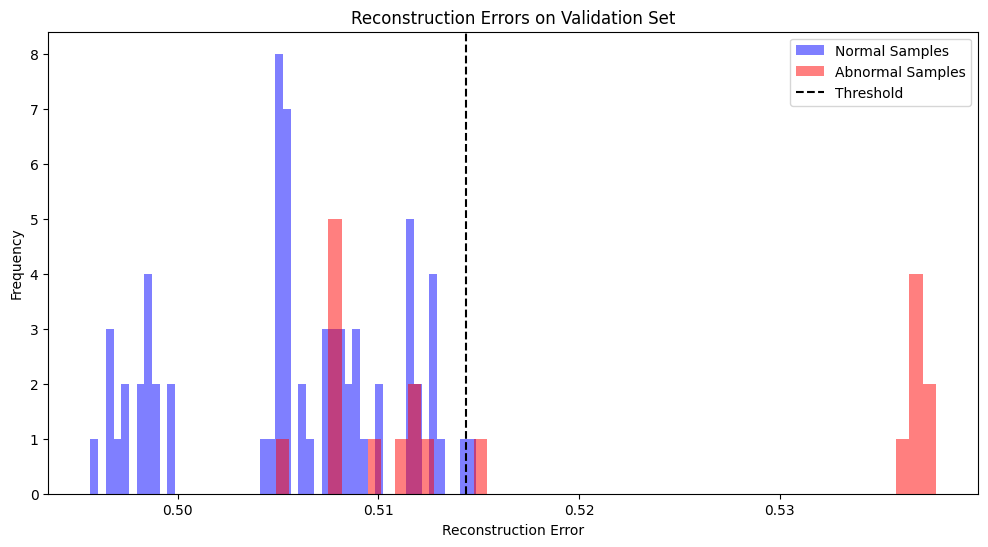

Best Threshold = 0.509618, Best F1 Score = 0.5556
Evaluation on Test Set:
Accuracy = 0.7272727272727273
Precision = 0.4166666666666667
Recall = 0.8333333333333334
F1 Score = 0.5555555555555556
Confusion Matrix:
 [[49 21]
 [ 3 15]]
Fold 2
Epoch 1/15, Loss: 1.143181
Epoch 2/15, Loss: 0.826764
Epoch 3/15, Loss: 0.568215
Epoch 4/15, Loss: 0.531148
Epoch 5/15, Loss: 0.527209
Epoch 6/15, Loss: 0.526499
Epoch 7/15, Loss: 0.525975
Epoch 8/15, Loss: 0.525485
Epoch 9/15, Loss: 0.525104
Epoch 10/15, Loss: 0.524695
Epoch 11/15, Loss: 0.524496
Epoch 12/15, Loss: 0.524248
Epoch 13/15, Loss: 0.524037
Epoch 14/15, Loss: 0.523745
Epoch 15/15, Loss: 0.523767
Best threshold: 0.512013543735851, Best F1 Score: 0.761904761904762


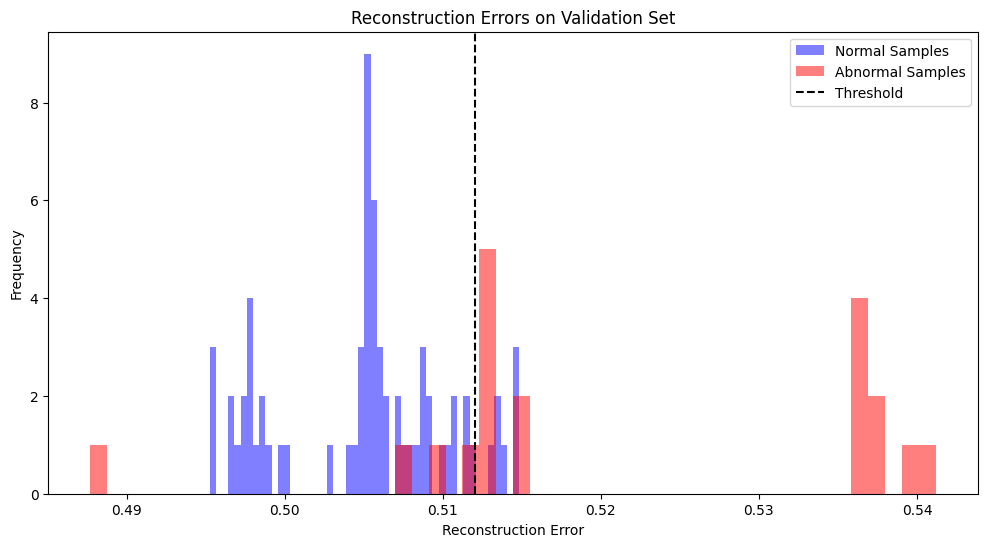

Best Threshold = 0.512350, Best F1 Score = 0.6500
Evaluation on Test Set:
Accuracy = 0.8409090909090909
Precision = 0.5909090909090909
Recall = 0.7222222222222222
F1 Score = 0.65
Confusion Matrix:
 [[61  9]
 [ 5 13]]
Fold 3
Epoch 1/15, Loss: 1.141095
Epoch 2/15, Loss: 0.811221
Epoch 3/15, Loss: 0.565876
Epoch 4/15, Loss: 0.531560
Epoch 5/15, Loss: 0.527451
Epoch 6/15, Loss: 0.526630
Epoch 7/15, Loss: 0.525982
Epoch 8/15, Loss: 0.525538
Epoch 9/15, Loss: 0.525054
Epoch 10/15, Loss: 0.524761
Epoch 11/15, Loss: 0.524507
Epoch 12/15, Loss: 0.524268
Epoch 13/15, Loss: 0.524005
Epoch 14/15, Loss: 0.523919
Epoch 15/15, Loss: 0.523714
Best threshold: 0.5134222290732644, Best F1 Score: 0.7333333333333334


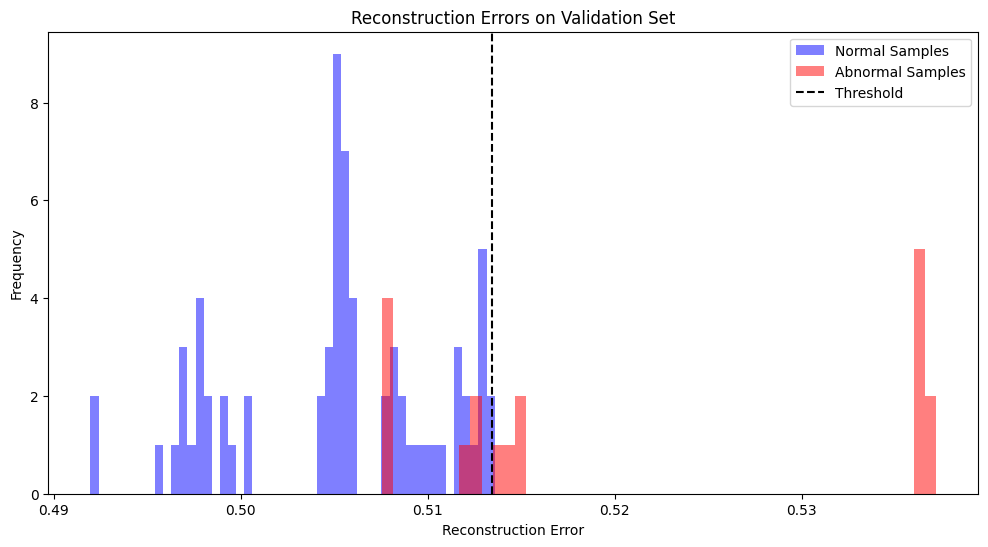

Best Threshold = 0.508332, Best F1 Score = 0.5085
Evaluation on Test Set:
Accuracy = 0.6666666666666666
Precision = 0.36585365853658536
Recall = 0.8333333333333334
F1 Score = 0.5084745762711864
Confusion Matrix:
 [[43 26]
 [ 3 15]]
Fold 4
Epoch 1/15, Loss: 1.144492
Epoch 2/15, Loss: 0.806246
Epoch 3/15, Loss: 0.562416
Epoch 4/15, Loss: 0.531015
Epoch 5/15, Loss: 0.527341
Epoch 6/15, Loss: 0.526424
Epoch 7/15, Loss: 0.525945
Epoch 8/15, Loss: 0.525358
Epoch 9/15, Loss: 0.525055
Epoch 10/15, Loss: 0.524769
Epoch 11/15, Loss: 0.524458
Epoch 12/15, Loss: 0.524243
Epoch 13/15, Loss: 0.524036
Epoch 14/15, Loss: 0.523905
Epoch 15/15, Loss: 0.523724
Best threshold: 0.509710765246189, Best F1 Score: 0.7317073170731708


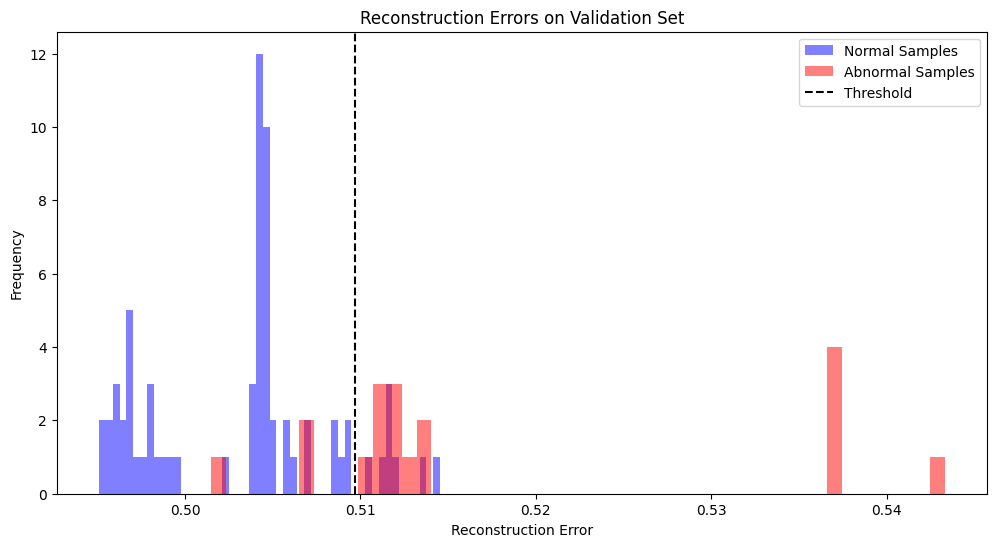

Best Threshold = 0.508483, Best F1 Score = 0.6250
Evaluation on Test Set:
Accuracy = 0.7931034482758621
Precision = 0.5
Recall = 0.8333333333333334
F1 Score = 0.625
Confusion Matrix:
 [[54 15]
 [ 3 15]]
Fold 5
Epoch 1/15, Loss: 1.139486
Epoch 2/15, Loss: 0.805999
Epoch 3/15, Loss: 0.564284
Epoch 4/15, Loss: 0.531688
Epoch 5/15, Loss: 0.527802
Epoch 6/15, Loss: 0.526939
Epoch 7/15, Loss: 0.526114
Epoch 8/15, Loss: 0.525634
Epoch 9/15, Loss: 0.525145
Epoch 10/15, Loss: 0.524826
Epoch 11/15, Loss: 0.524496
Epoch 12/15, Loss: 0.524322
Epoch 13/15, Loss: 0.524104
Epoch 14/15, Loss: 0.524011
Epoch 15/15, Loss: 0.523736
Best threshold: 0.5114403132236365, Best F1 Score: 0.7142857142857143


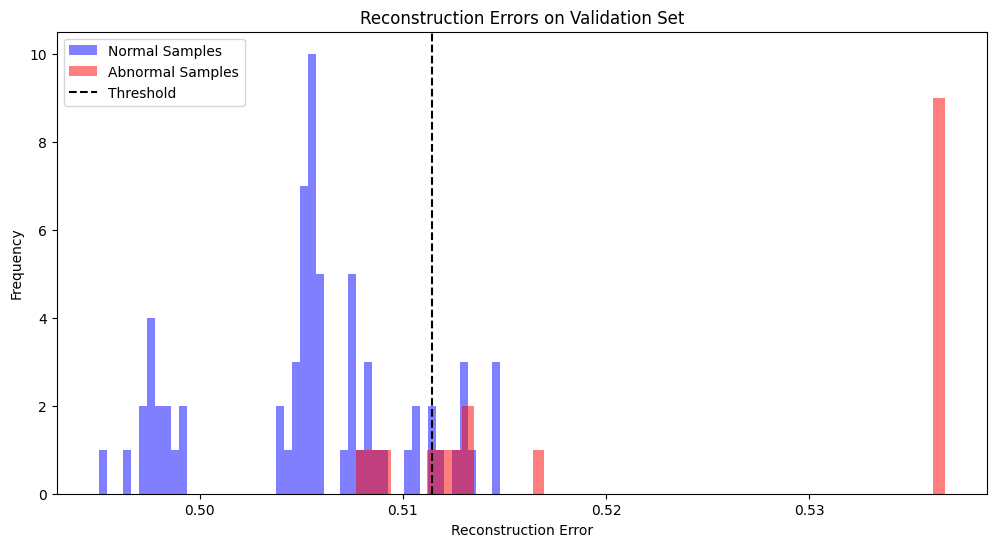

Best Threshold = 0.515239, Best F1 Score = 0.6667
Evaluation on Test Set:
Accuracy = 0.896551724137931
Precision = 1.0
Recall = 0.5
F1 Score = 0.6666666666666666
Confusion Matrix:
 [[69  0]
 [ 9  9]]


In [18]:

for fold, (train_idx, val_idx) in enumerate(skf.split(features_original, label)):
    
    print(f"Fold {fold + 1}")
    
   # Get full fold data
    fold_data, fold_labels = features_original[train_idx], label[train_idx]
    val_data, val_labels = features_original[val_idx], label[val_idx]
   
    # Split into training and validation folds
    X_train, X_temp, y_train, y_temp = train_test_split(fold_data, fold_labels, test_size=0.2, shuffle=True, random_state=42)
    X_val, X_test, y_val, y_test = train_test_split(val_data, val_labels, test_size=0.5, shuffle=True, random_state=42)


    # Train autoencoder on the training fold
    model = train_autoencoder(features_normal, epochs=15, batch_size=64)

    # Add channel dimension to X_val
    X_val = X_val[:, np.newaxis, :]

    # Evaluate on validation fold
    val_normal = X_val[y_val == 0]
    val_abnormal = X_val[y_val == 1]
    val_errors_normal = compute_reconstruction_loss(model, val_normal)
    val_errors_abnormal = compute_reconstruction_loss(model, val_abnormal)
    val_errors = np.concatenate([val_errors_normal, val_errors_abnormal])
    y_val_combined = np.concatenate([np.zeros(len(val_errors_normal)), np.ones(len(val_errors_abnormal))])
    
    threshold, best_f1 = find_best_threshold(val_errors, y_val_combined)
    print(f"Best threshold: {threshold}, Best F1 Score: {best_f1}")

    # Plot histogram of reconstruction errors on both normal and abnormal samples
    plt.figure(figsize=(12, 6))
    plt.hist(val_errors_normal, bins=50, alpha=0.5, label='Normal Samples', color='blue')
    plt.hist(val_errors_abnormal, bins=50, alpha=0.5, label='Abnormal Samples', color='red')
    plt.axvline(threshold, color='black', linestyle='--', label='Threshold')
    plt.title('Reconstruction Errors on Validation Set')
    plt.xlabel('Reconstruction Error')
    plt.ylabel('Frequency')
    plt.legend()
    plt.show()

    
    X_test = X_test[:, np.newaxis, :]  # Add channel dimension
    val_errors_test = compute_reconstruction_loss(model, X_test)
    
    
    # Evaluate on test set
    evaluate_on_test_with_threshold_search(model, X_test, y_test)



# Observation:

Accuracy = 0.9142857142857143

Precision = 0.6

Recall = 0.35294117647058826

F1 Score = 0.4444444444444445

Confusion Matrix:

 [[154   4]
 
 [ 11   6]]



